# AI in Biomedicine and Healthcare [BM5020]
# Project : Vessel and tissue recognition during third-space Endoscopy using a deep learning algorithm
## Team Members
- **Pradeep Mundlik, ai21btech11022@iith.ac.in**
- **Naman Chhibbar, ma21btech110xx@iith.ac.in**

#### Link to Github Repository: [Github](https://github.com/NamanChhibbar/BM5020-Project)
#### Link to Paper PPT: [Slides](https://docs.google.com/presentation/d/1uuP4rpO48ZUkxz7x2UBRvn2n522-tvPUc-YlY8JwQa8/edit?usp=sharing)


***This notebook contains the main code for the project. It includes the implementation of various algorithms and functions related to the project along with output to help with our analysis.***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchsummary import summary
from torchviz import make_dot
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import urllib
from matplotlib import cm
import cv2

/home/pradeep/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def postprocess_output(output, num_classes):
    output_np = output.cpu().numpy().squeeze()
    segmentation_map = np.argmax(output_np, axis=0)
    print(np.unique(segmentation_map))
    segmentation_map = cm.tab20(segmentation_map.astype(float) / num_classes)
    return segmentation_map

def overlay_segmentation_mask(image, segmentation_map):
    # if image and segmentation_map are tensors, convert them to numpy arrays
    if torch.is_tensor(image):
        image = image.cpu().numpy()
        
    if torch.is_tensor(segmentation_map):
        segmentation_map = segmentation_map.cpu().numpy()
    segmentation_map = segmentation_map[:, :, :3]
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = image.astype(np.float32)
    segmentation_map = segmentation_map.astype(np.float32)
    image = cv2.addWeighted(image, 0.05, segmentation_map, 0.95, 0)
    return image

def visualize_results(image, segmentation_map):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Input Image')
    axs[1].imshow(segmentation_map)
    axs[1].set_title('Segmentation Mask')
    axs[2].imshow(overlay_segmentation_mask(image, segmentation_map))
    axs[2].set_title('Overlay')
    plt.show()

In [9]:
# defining the model
class Resnest(nn.Module):
    def __init__(self, model_name='resnest101e'):
        super(Resnest, self).__init__()
        self.model = models.resnet101(weights = models.ResNet101_Weights.IMAGENET1K_V2)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Identity(n_features)

    def forward(self, x):
        x = self.model(x)
        x = x.unsqueeze(2)
        x = x.unsqueeze(2)
        return {"out": x, "aux": x} 
    
# define the preprocessing function
def preprocess(image):
    image = image.convert('RGB')
    image = np.array(image)
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float32)
    image /= 255.0
    normalise = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalise(image)
    return image


In [12]:
# define the model
clf = models.segmentation.deeplabv3.DeepLabHead(2048, 21)
aux_clf = models.segmentation.deeplabv3.FCNHead(2048, 21)
model = models.segmentation.DeepLabV3(backbone=Resnest(), classifier=clf, aux_classifier=aux_clf)
# print(model)

In [13]:
# try to visualize the model
image = Image.open('dog.jpg')
image = preprocess(image)
model.eval()

# predict
with torch.no_grad():
    output = model(image.unsqueeze(0))
    print(output.keys())
    # print(output)

odict_keys(['out', 'aux'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 21, 1213, 1546])
[14]
(1213, 1546, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


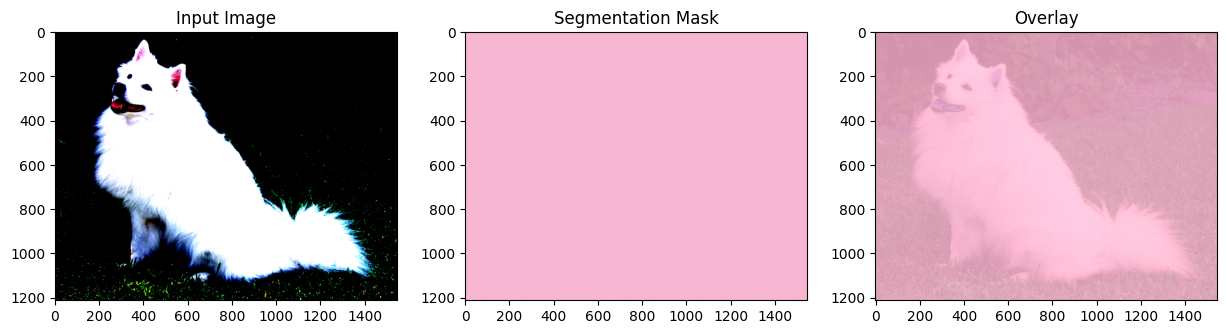

In [14]:
print(output['out'].shape)
# print(image.shape)
out_image = postprocess_output(output['out'], 21)
print(out_image.shape)
visualize_results(np.transpose(image, (1,2,0)), out_image)

In [19]:
# import deeplatv3+ model from torchvision
weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
backbone_weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.segmentation.deeplabv3_resnet101(weights=weights, weights_backbone=backbone_weights)

In [31]:
image = Image.open('data/Snapshots/M_01022024131810_20698051_1_001_0001-01.MP4-frame773.jpg')
image = np.asarray(image)
image = image[:, 400:, :]
image = Image.fromarray(image)

In [32]:
image = preprocess(image)
model.eval()

# predict
with torch.no_grad():
    output = model(image.unsqueeze(0))
    # print(output)
    
print(output.keys())
output = output['out']
print(output.shape)

odict_keys(['out', 'aux'])
torch.Size([1, 21, 720, 880])


In [21]:
# print(model)

In [33]:
print(output.shape)
out_image = postprocess_output(output, 21)
print(out_image.shape)

torch.Size([1, 21, 720, 880])
[ 0 15]
(720, 880, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


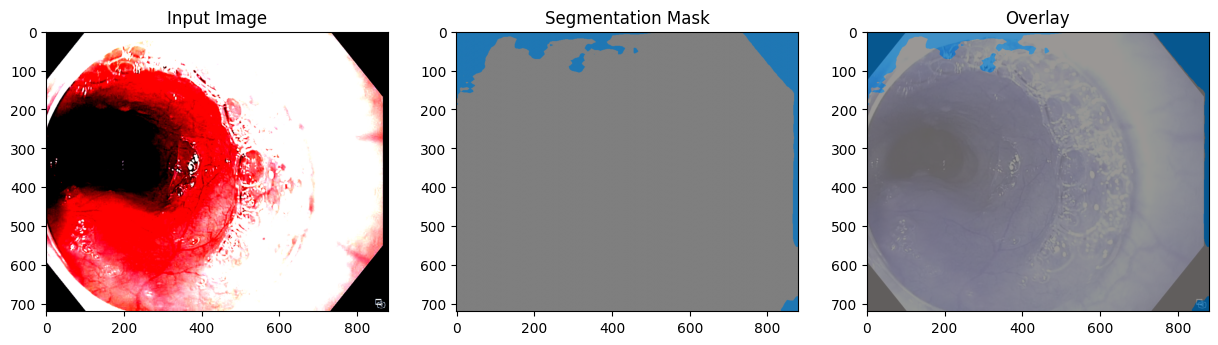

In [34]:
visualize_results(np.transpose(image, (1,2,0)), out_image)